# Overscan

The overscan region of a CCD, if present, is a part of the chip that is covered.
Depending on the camera, it can be a useful way to remove small variations in
the bias level from frame to frame.

However, whether or not the overscan is useful depends on the camera. It's
advisable to examine the overscan part of the camera you're using before
deciding if you should include it in image reduction.

One important note: *overscan always includes bias, read noise, and dark
current*. The overscan pixels are still pixels, and just like any other pixel
includes dark current and is subject to read noise. Many sources describe
overscan as correcting for bias, but if the dark current for the camera is
negligible, as it often is for cryogenically cooled cameras, then the overscan
is essentially bias.

The read noise in the overscan is reduced by averaging over the overscan region.
That will be covered in a later notebook; this notebook focuses on what the
overscan looks like and how to decide whether or not to use it.

In this notebook we will look at the overscan region for two different cameras,
a cryogenically cooled camera in which the overscan provides useful information
and a thermo-electrically cooled camera in which the overscan does not provide
useful information.

In [1]:
from pathlib import Path

from astropy.nddata import CCDData
from astropy.visualization import hist
from ccdproc import subtract_overscan
import matplotlib.pyplot as plt

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Case 1: Cryogenically cooled Large Format Camera (LFC) at Palomar

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R69){:target="_blank"}

The images below are from chip 0 of the LFC at the Palomar 200-inch telescope.
Technical information about the camera is [here](http://www.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html). It
turns out that the images are not actually 2048 × 4096; as you can see below,
the images are 2080 × 4128. The "extra" in each direction is overscan.

The FITS header for these files includes the keyword `BIASSEC`, which indicates
the nominal extent of the overscan region. Its value is `[2049:2080,1:4127]`,
which indicates the overscan extends from 2048 to 2079 (Python indexing starts
at 0, not 1 like in FITS) in the "short" direction and over the entire chip in
the other direction. As we'll see shortly, the useful overscan region is smaller
than this.

We'll focus here on the overscan in the side that is nominally 2048 wide; in
Python that's the second index. The pixel count cross-sections plotted below are
from a bias, science, and flat image. Flat images are particularly helpful in
evaluating how much of the overscan region is useful because the average pixel
value in the exposed part of the camera is typically large.

In [3]:
cryo_path = Path('example-cryo-LFC')
bias_lfc = CCDData.read(cryo_path / 'ccd.001.0.fits', unit='count')
science_g_lfc = CCDData.read(cryo_path / 'ccd.037.0.fits', unit='count')
flat_g_lfc = CCDData.read(cryo_path / 'ccd.014.0.fits', unit='count')

In [4]:
bias_lfc.shape

(4128, 2080)

Text(0.5, 1.0, 'Overscan region, averaged over all rows')

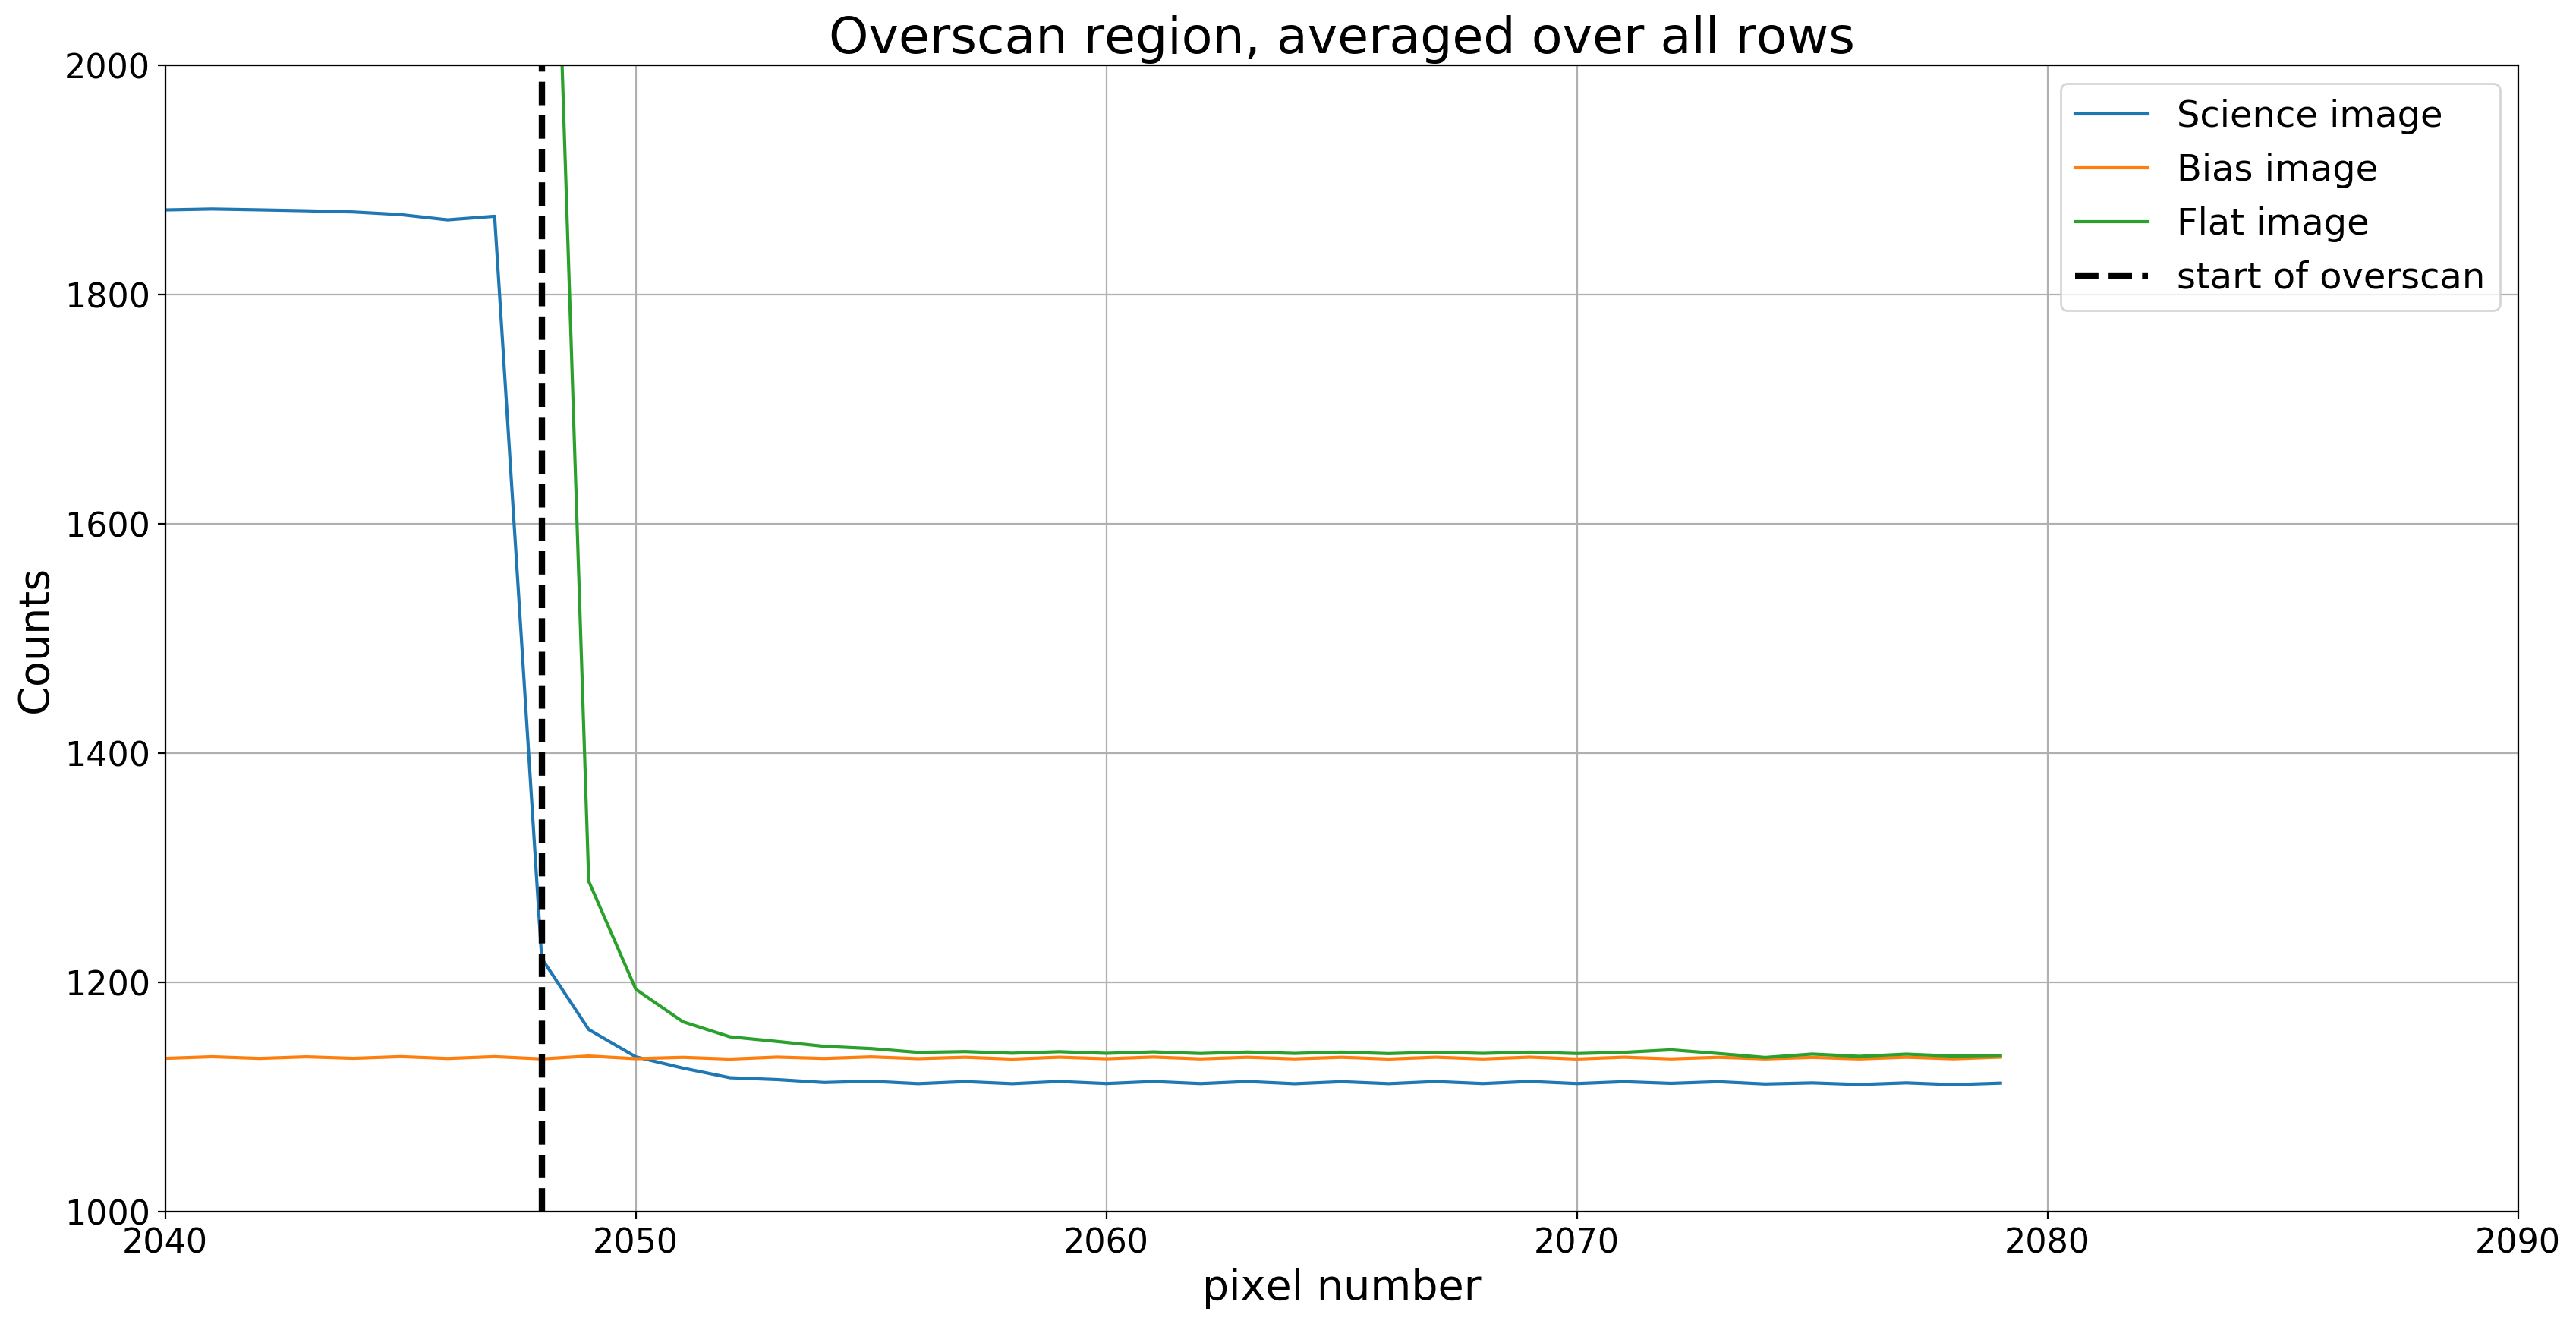

In [5]:
plt.figure(figsize=(20,10))
plt.plot(science_g_lfc.data.mean(axis=0), label='Science image')
plt.plot(bias_lfc.data.mean(axis=0), label='Bias image')
plt.plot(flat_g_lfc.data.mean(axis=0), label='Flat image')
plt.grid()
plt.axvline(x=2048, color='black', linewidth=3, linestyle='dashed', label='start of overscan')
plt.legend()
plt.ylim(1000, 2000)
plt.xlim(2040, 2090)
plt.xlabel('pixel number')
plt.ylabel('Counts')
plt.title('Overscan region, averaged over all rows')

### Discussion of Example 1

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R135){:target="_blank"}

There are a few interesting things here.

**The count value is nearly uniform in the overscan region.**

This is good; ideally the overscan is nearly uniform since the pixels are not
illuminated.

**Some light leaks from the imaging region into the overscan region.**

This is
clearest in the flat image, where the counts are much higher than the value to
which they asymptote until at least pixel number 2055.

Though the FITS header indicates the overscan starts at pixel 2048, the *useful*
part of the overscan (i.e. the part not contaminated by light) extends from
pixel 2055 to the end.

**There is an offset between the science image and the other two images, and
perhaps between the flat and bias images.**

This sort of variation is what overscan is intended to correct. It could be that
this one science image has a different overscan value (it was taken several
hours after the flat image) or it could be that all science images have a
different overscan value than other types of images.

Either way, subtracting overscan from each of the images allows for correction
of these offsets.

**Dark current *in this camera* is essentially zero so the overscan is
measuring bias.**

To be clear, this isn't apparent from the graph above, but cryogenically cooled
cameras have negligible dark current.

#### What happens if you don't use the overscan?

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R171){:target="_blank"}

Nothing particularly bad. In the specific case above, ignoring the overscan will
shift the background level in the science image by roughly 20 counts, since the
difference between the overscan region of the science image is lower than the
overscan in the other images by roughly 20 counts. If, before doing science, the
background of those images is subtracted, then this shift should be removed with
the background.

### Conclusion for case 1

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R185){:target="_blank"}

The overscan is useful, but the usable overscan region extends from 2055 to the
end of the chip rather than from 2048 to end of the chip as the FITS header
claims. Put a little differently, the appropriate `BIASSEC` for these images is
`[2056:2080,1:4127]`. (Note that FITS starts numbering at 1 instead of 0, so
2055 in Python is 2056 in FITS notation.)

If the science you are using requires knowing the counts to a precision of a
count or two, and modeling the background in the science image isn't an option,
consider using the overscan.

## Case 2: Thermo-electrically cooled Apogee Aspen CG16M

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R202){:target="_blank"}

This is a low-end, research-grade CCD sold by Andor. Basic information is
[here](https://andor.oxinst.com/assets/uploads/documents/Andor/apogee/Apogee_Aspen_CG16M_Specifications.pdf), though you need to track down the description
of the sensor chip, [KAF-16803 CCD](http://www.onsemi.com/pub/Collateral/KAF-16803-D.PDF) to find out that the
overscan region of this 4096 × 4096 pixel camera extends from pixel 4097 to 4109
along one of the directions.

In [6]:
therma_path = Path('example-thermo-electric')
kelt = CCDData.read(therma_path / 'kelt-16-b-S001-R001-C084-r.fit', unit='adu')
dark1000 = CCDData.read('dark-test-0002d1000.fit.bz2', unit='adu')
flat = CCDData.read(therma_path / 'AutoFlat-PANoRot-r-Bin1-006.fit', unit='adu')
master = CCDData.read('combined_bias_100_images.fit.bz2', unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


(900, 1300)

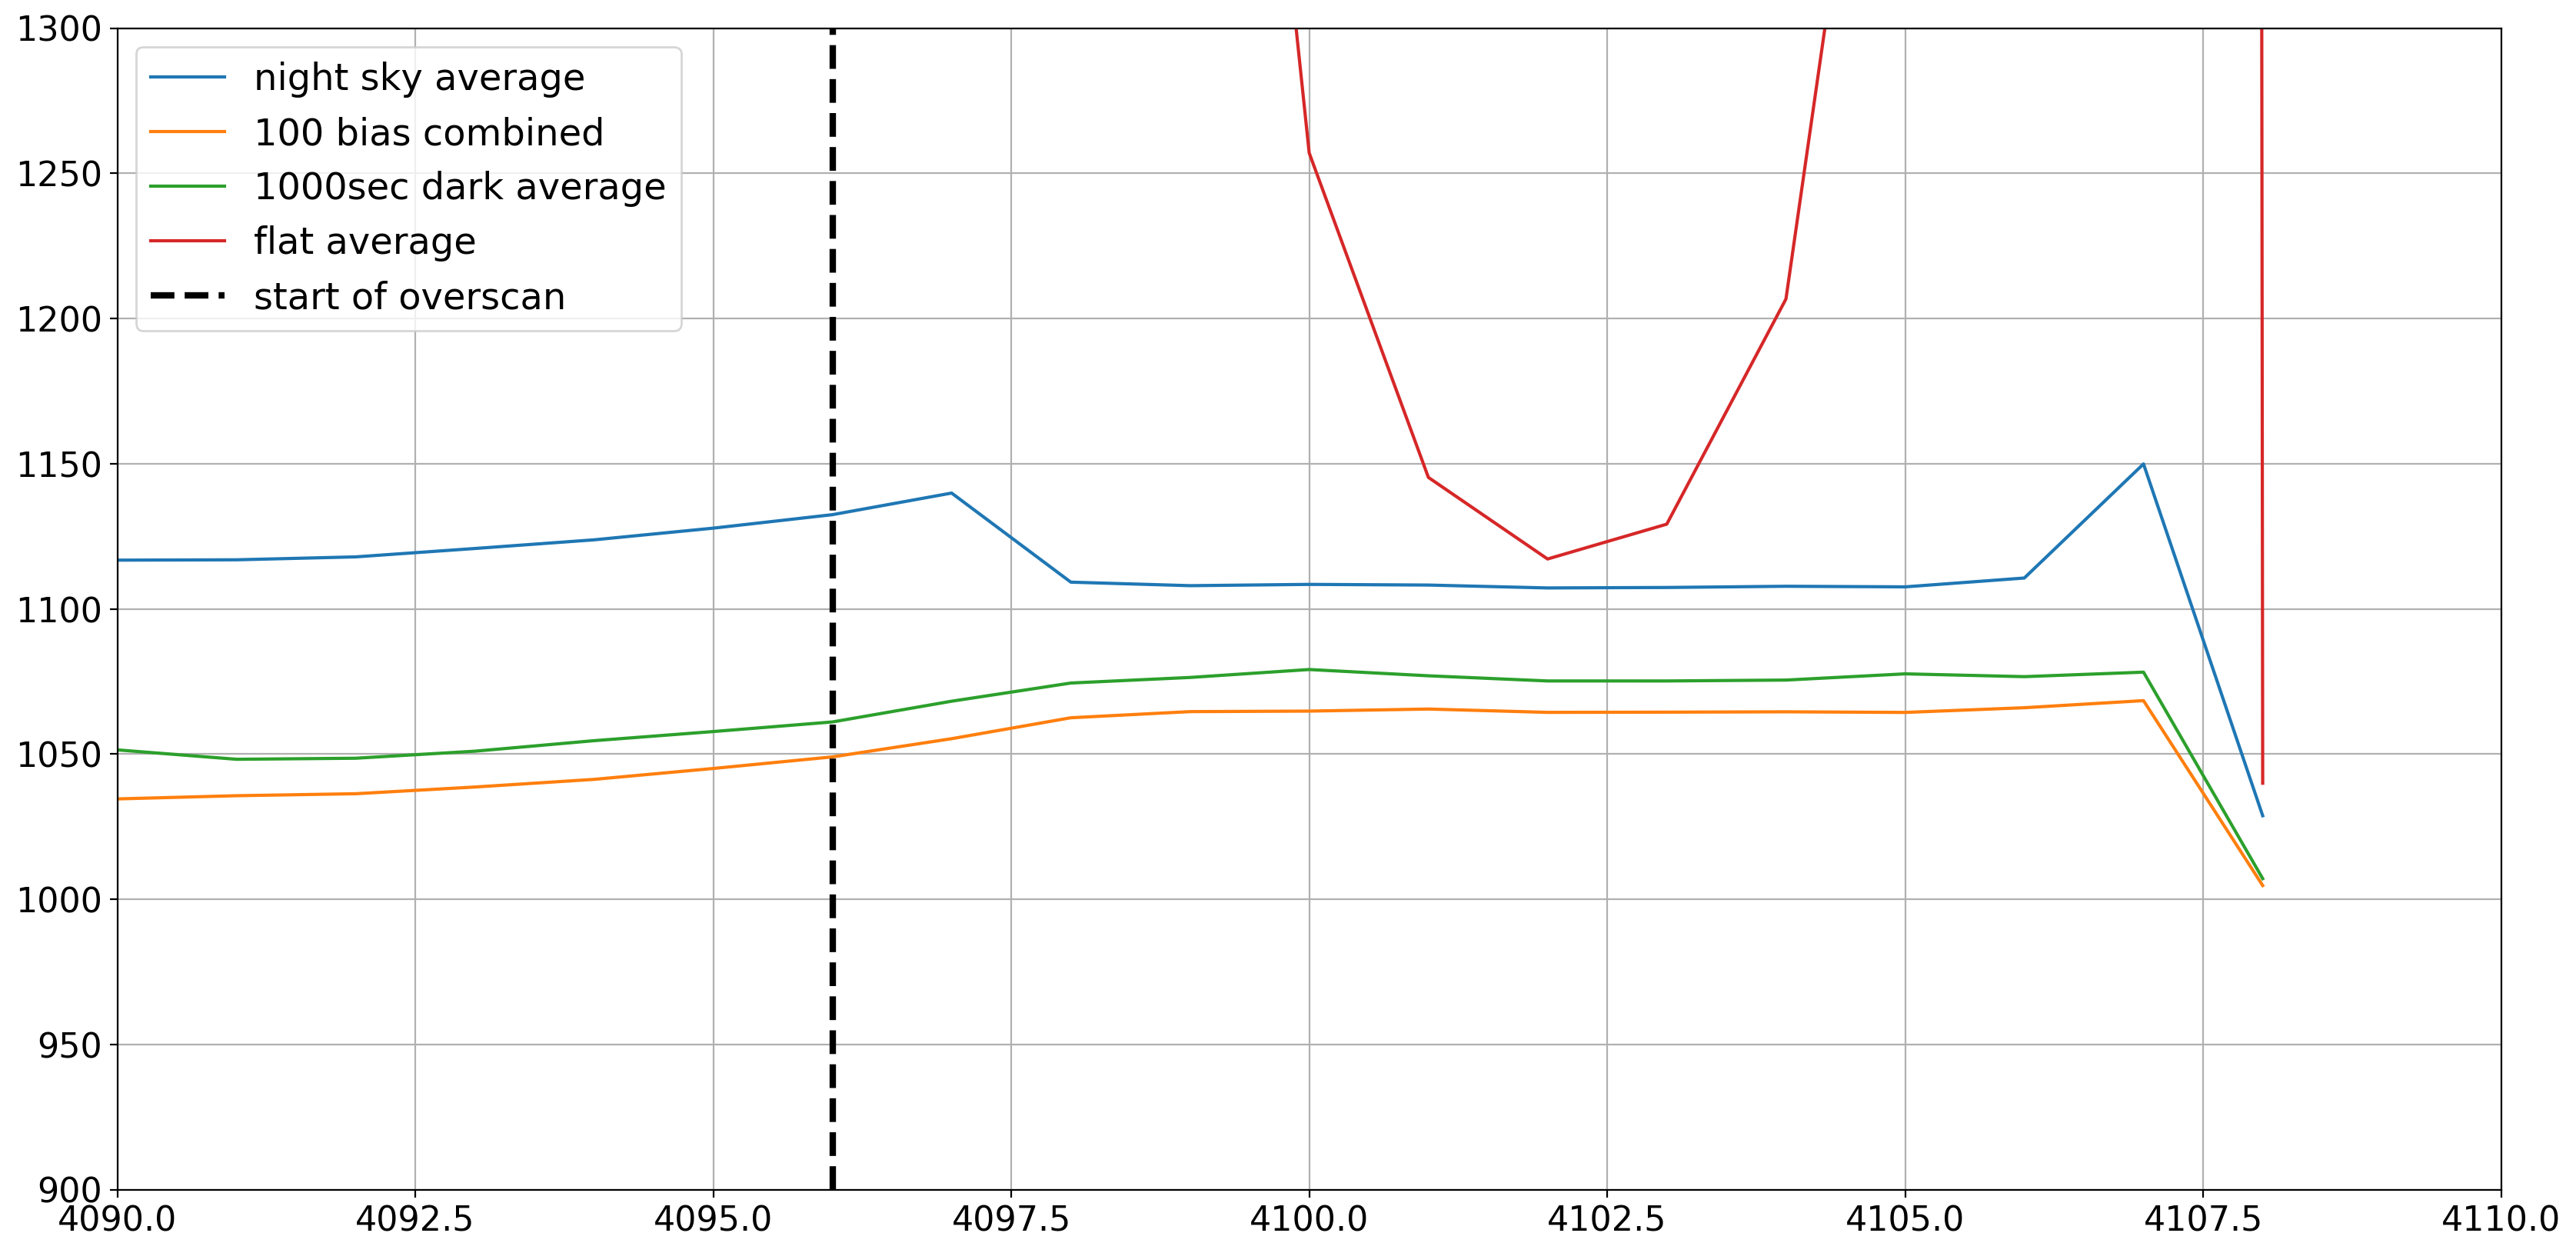

In [7]:
plt.figure(figsize=(20,10))

plt.plot(kelt.data.mean(axis=0), label='night sky average')
plt.plot(master.data.mean(axis=0), label='100 bias combined')
plt.plot(dark1000.data.mean(axis=0), label='1000sec dark average')
plt.plot(flat.data.mean(axis=0), label='flat average')

plt.grid()
plt.axvline(x=4096, color='black', linewidth=3, linestyle='dashed', label='start of overscan')
plt.legend()
plt.xlim(4090, 4110)
plt.ylim(900, 1300)

### Discussion of Example 2

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R248){:target="_blank"}

The camera also has some interesting features.

**Count values change quite a bit in the overscan region**

This is clearest in the overscan for the flat. Not only is light leaking into
the overscan, the overscan appears to be mostly light leakage. One pixel may be
useful at best.

**Overscan includes dark current**

The overscan for the dark image in the figure above is roughly 10 counts higher
than the counts for the bias. The dark current for this camera is roughly 0.01
counts/pixel/second. For a 1000 second dark exposure, the expected dark counts
are about 10, which is the difference seen in the graph.

**There is an offset between the bias/dark and science/flat images**

The offset in this camera is roughly 50 counts. It's large enough that one ought
to be hesitant to use the overscan for this camera.

**The overscan counts are higher than the average bias counts**

Note that for the bias image, counts increase up to the pixel where overscan
starts and then level out. It turns out that overscan counts are *higher* than
the average of the bias counts, so subtracting the overscan would lead to a bias
image that is negative. This is another reason to be suspicious of the overscan
region on this camera.

### Conclusion for case 2

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/213/files#diff-a39dc0de1b4b0c208cdeeb55123683a9R283){:target="_blank"}

Do not use the overscan in this case. There are serious issues with light
leakage and large differences in the overscan counts between the bias and
science images.